In [1]:
%matplotlib inline
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB,ComplementNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns

from sklearn.metrics import precision_recall_fscore_support

from sklearn.model_selection import KFold

from spacy.lang.en.stop_words import STOP_WORDS

import spacy


In [2]:
#df = pd.read_csv("train 2.csv", encoding = "ISO-8859-1")
df = pd.read_csv("../data/processed/all_data_US_QA.csv")
df_all_raw_data = pd.read_csv("../data/raw/all_last_data/all.csv")#.drop(["User-centric?","Contains QA?"],axis =1)
df_all_raw_data = df_all_raw_data[df_all_raw_data["Contains QA?"]=="Yes"]
df_all_raw_data = df_all_raw_data.fillna("")


df_all_raw_data.head()

train = pd.read_csv("../data/processed/train_data_US_QA.csv").drop(["user_centric_bool","user_centric_val","contains_QA_val","contains_QA_bool","Unnamed: 0","User-centric?","Contains QA?","QA Name 1","QA Name 2","label_vec","label_json"],axis =1)
test = pd.read_csv("../data/processed/test_data_US_QA.csv").drop(["user_centric_bool","user_centric_val","contains_QA_val","contains_QA_bool","Unnamed: 0","User-centric?","Contains QA?","QA Name 1","QA Name 2","label_vec","label_json"],axis =1)
print("train : ",len(train))
print("test : ",len(test))


df_30 = pd.read_csv("../data/processed/all_data_US_QA.csv")


len(df_all_raw_data)

train :  593
test :  280


434

## On test mtn avec les même donnée que spayc (data/processed/all_data_US_QA_2.csv)

In [49]:

df = pd.read_csv("../data/processed/all_data_US_QA_2.csv")
df_all_raw_data = df.drop(["user_centric_bool","user_centric_val","contains_QA_val","contains_QA_bool","Unnamed: 0","User-centric?","Contains QA?","QA Name 1","QA Name 2","label_vec","label_json"],axis =1)



df_all_raw_data = df_all_raw_data.fillna("")
df_all_raw_data.head()

bakclog_id                                         User story  performance  \
0    all.csv  As a Publisher, I want to be warned that a tag...          0.0   
1    all.csv  As the Digital Records Archivist, I need the b...          0.0   
2    all.csv  As an archivist, I want to mark individual fil...          0.0   
3    all.csv  As a Cornell faculty member, I want to see cle...          0.0   
4    all.csv  As a Staff member, I want to Develop a Staff R...          0.0   

   compatibility  usability  reliability  security  maintainability  \
0            0.0        1.0          0.0       0.0              0.0   
1            0.0        0.0          0.0       1.0              0.0   
2            0.0        0.0          0.0       1.0              0.0   
3            0.0        0.0          0.0       0.0              0.0   
4            0.0        0.0          0.0       0.0              0.0   

   portability  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0

# On récup les données balance pour détection QA

In [3]:
df_QA_bal = pd.read_csv("../data/processed/contain_QA/all_data_QA.csv")
#df_QA_bal = df.drop(["user_centric_bool","user_centric_val","contains_QA_val","contains_QA_bool","Unnamed: 0","User-centric?","Contains QA?","QA Name 1","QA Name 2","label_vec","label_json"],axis =1)



df_QA_bal = df_QA_bal.fillna("")
print(len(df_QA_bal))
df_QA_bal.head()

868


Unnamed: 0                                         User story  \
0        1203  As an UnivITservice, I want to be able to expo...   
1        1663  As a FABS user, I want additional helpful info...   
2         780  As a user, I want to have the ability to move ...   
3        1112  As an Archivist, I want to see Dates and Exten...   
4         182  As a Developer, I want an EPrints integration,...   

  User-centric? Contains QA?      QA Name 1 QA Name 2               label_vec  \
0            No           No                           [0. 0. 0. 0. 0. 0. 0.]   
1           Yes           No                           [0. 0. 0. 0. 0. 0. 0.]   
2           Yes          Yes      usability            [0. 0. 1. 0. 0. 0. 0.]   
3           Yes           No                           [0. 0. 0. 0. 0. 0. 0.]   
4            No          Yes  compatibility            [0. 1. 0. 0. 0. 0. 0.]   

   performance  compatibility  usability  reliability  security  \
0          0.0            0.0        0.0          0.0       0.0   
1          0.0            0.0        0.0          0.0       0.0   
2          0.0            0.0        1.0          0.0       0.0   
3          0.0            0.0        0.0          0.0       0.0   
4          0.0            1.0        0.0          0.0       0.0   

   maintainability  portability  \
0              0.0          0.0   
1              0.0          0.0   
2              0.0          0.0   
3              0.0          0.0   
4              0.0          0.0   

                                          label_json  user_centric_bool  \
0  {"performance": 0.0, "compatibility": 0.0, "us...              False   
1  {"performance": 0.0, "compatibility": 0.0, "us...               True   
2  {"performance": 0.0, "compatibility": 0.0, "us...               True   
3  {"performance": 0.0, "compatibility": 0.0, "us...               True   
4  {"performance": 0.0, "compatibility": 1.0, "us...              False   

   contains_QA_bool  user_centric_val  contains_QA_val  
0             False                 0                0  
1             False                 1                0  
2              True                 1                1  
3             False                 1                0  
4              True                 0                1

In [6]:
nlp=spacy.load("en")

df_QA_bal['User story'] = df_QA_bal['User story'].map(lambda com : clean_sent(clean_text(com)))
print(len(df_QA_bal))
df_QA_bal.head()

868


Unnamed: 0                                         User story  \
0        1203  Univitservice Want Able Export Datum Different...   
1        1663  Fabs User Want Additional Helpful Info Submiss...   
2         780  User Want Ability Multiple File Rearrange Use ...   
3        1112  Archivist Want Date Extent Display Read Edit V...   
4         182  Developer Want Eprint Integration Integrate Da...   

  User-centric? Contains QA?      QA Name 1 QA Name 2               label_vec  \
0            No           No                           [0. 0. 0. 0. 0. 0. 0.]   
1           Yes           No                           [0. 0. 0. 0. 0. 0. 0.]   
2           Yes          Yes      usability            [0. 0. 1. 0. 0. 0. 0.]   
3           Yes           No                           [0. 0. 0. 0. 0. 0. 0.]   
4            No          Yes  compatibility            [0. 1. 0. 0. 0. 0. 0.]   

   performance  compatibility  usability  reliability  security  \
0          0.0            0.0        0.0          0.0       0.0   
1          0.0            0.0        0.0          0.0       0.0   
2          0.0            0.0        1.0          0.0       0.0   
3          0.0            0.0        0.0          0.0       0.0   
4          0.0            1.0        0.0          0.0       0.0   

   maintainability  portability  \
0              0.0          0.0   
1              0.0          0.0   
2              0.0          0.0   
3              0.0          0.0   
4              0.0          0.0   

                                          label_json  user_centric_bool  \
0  {"performance": 0.0, "compatibility": 0.0, "us...              False   
1  {"performance": 0.0, "compatibility": 0.0, "us...               True   
2  {"performance": 0.0, "compatibility": 0.0, "us...               True   
3  {"performance": 0.0, "compatibility": 0.0, "us...               True   
4  {"performance": 0.0, "compatibility": 1.0, "us...              False   

   contains_QA_bool  user_centric_val  contains_QA_val  
0             False                 0                0  
1             False                 1                0  
2              True                 1                1  
3             False                 1                0  
4              True                 0                1

In [7]:
print(len(df_QA_bal))
print(len(df_QA_bal[df_QA_bal["Contains QA?"]=="Yes"]))
print(len(df_QA_bal[df_QA_bal["Contains QA?"]=="No"]))


     
df_QA_bal["User story"][0:5]

868
434
434


0    Univitservice Want Able Export Datum Different...
1    Fabs User Want Additional Helpful Info Submiss...
2    User Want Ability Multiple File Rearrange Use ...
3    Archivist Want Date Extent Display Read Edit V...
4    Developer Want Eprint Integration Integrate Da...
Name: User story, dtype: object

In [5]:
list_QA = ["performance", "compatibility", "usability", "reliability", "security", "maintainability", "portability"]
dic_QA = {}

for i in range(0,len(list_QA)):
    dic_QA[list_QA[i]] = i

def create_vec_QA(data):
    vec_QA = np.zeros(len(list_QA))
    for d in data :
        if d != "" :
            vec_QA[dic_QA[d]] = 1
    return vec_QA
def create_label_json(vec_QA):
    json_lab = {}
    for i in range(0,len(list_QA)):
        json_lab[list_QA[i]] = vec_QA[0][i] #(vec_QA[0][i] == 1)
    return json_lab
            

list_vec_QA = list(df_all_raw_data[["QA Name 1","QA Name 2"]].apply(create_vec_QA, axis=1))

matrix_vec_QA = np.array(list_vec_QA)

for i in range(0,len(list_QA)):
    df_all_raw_data[list_QA[i]] = matrix_vec_QA[:,i]

  
df = df_all_raw_data.drop(["QA Name 1","QA Name 2"],axis =1)
print(len(df))
df.head()

434


User story User-centric?  \
0   As a ProspectiveApplicant, I want to research ...           Yes   
2   As a Customer, I want to Create a Customer Por...           Yes   
6   As an Applicant, I want to Check the Status of...           Yes   
20  As a Planning Staff member, I want to Generate...           Yes   
51  As a Staff member, I need to be notified when ...           Yes   

   Contains QA?  performance  compatibility  usability  reliability  security  \
0           Yes          0.0            0.0        1.0          0.0       0.0   
2           Yes          0.0            0.0        0.0          0.0       1.0   
6           Yes          0.0            0.0        1.0          0.0       0.0   
20          Yes          0.0            1.0        0.0          0.0       0.0   
51          Yes          0.0            0.0        1.0          0.0       0.0   

    maintainability  portability  
0               0.0          0.0  
2               0.0          0.0  
6               0.0          0.0  
20              0.0          0.0  
51              0.0          0.0

### Number of comments in each category

In [6]:
def count_label_df(df):
    df_toxic = df.drop(['User story'], axis=1)
    counts = []
    categories = list(df_toxic.columns.values)
    for i in categories:
        counts.apppend((i, df_toxic[i].sum()))
    df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
    return df_stats
count_label_df(df)

category                                 number_of_comments
0    User-centric?  YesYesYesYesYesYesYesYesYesYesYesYesYesYesYesY...
1     Contains QA?  YesYesYesYesYesYesYesYesYesYesYesYesYesYesYesY...
2      performance                                                 31
3    compatibility                                                165
4        usability                                                 80
5      reliability                                                 28
6         security                                                 97
7  maintainability                                                 57
8      portability                                                 25

In [8]:
count_label_df(train)

category  number_of_comments
0      performance                30.0
1    compatibility               127.0
2        usability                58.0
3      reliability                20.0
4         security                70.0
5  maintainability                54.0
6      portability                25.0

In [7]:
count_label_df(test)

category  number_of_comments
0      performance                 9.0
1    compatibility                57.0
2        usability                26.0
3      reliability                10.0
4         security                34.0
5  maintainability                17.0
6      portability                10.0

In [8]:
df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

NameError: name 'df_stats' is not defined

### Multi-Label

How many comments have multiple labels?

356  of US with  2.0  Qualities
297  of US with  5.0  Qualities
84  of US with  3.0  Qualities
53  of US with  0.0  Qualities
27  of US with  4.0  Qualities
24  of US with  6.0  Qualities


Text(0.5, 0, '# of Quality Attribute :')

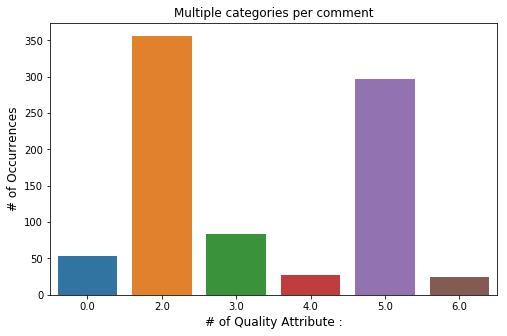

In [9]:
rowsums = df.iloc[:,1:].sum(axis=1)
x=rowsums.value_counts()

for i in range(0,len(x)):
    print(x.values[i]," of US with ",x.index[i]," Qualities")


#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of Quality Attribute :', fontsize=12)

Vast majority of the comment texts are not labeled.

The distribution of the number of words in comment texts.

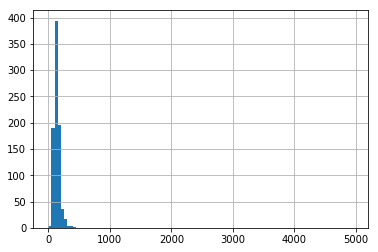

In [10]:
lens = df["User story"].str.len()
lens.hist(bins = np.arange(0,5000,50))

Most of the comment text length are within 500 characters, with some outliers up to 5,000 characters long.

In [11]:
print('Percentage of comments that are not labelled:')

print(len(df[(df['performance']==0) & (df['compatibility']==0) & (df['usability']==0) & (df['reliability']== 0) & (df['security']==0) & (df['maintainability']==0) & (df['portability']==0)]) / len(df))

Percentage of comments that are not labelled:
0.4863258026159334


There is no missing comment in comment text column.

Have a peek the first comment, the text needs clean.

In [12]:
df['User story'][0]

"As a Publisher, I want to be warned that a tag exists when I try to overwrite it, so that that I don't accidentally overwrite stable tagged data which is relied on by consumers."

In [14]:
categories = ["performance", "compatibility", "usability", "reliability", "security", "maintainability", "portability"]



### Create a function to clean the text

In [5]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text
def clean_sent(sent):
    """
    Converts all sent words to lem and removes all pronouns or stopwords
    """
    doc = nlp(sent)
    tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
    tokens = [tok[0].upper()+tok[1:] for tok in tokens if tok not in STOP_WORDS and tok != ""]
    new_sent = ' '.join(tokens)

    return new_sent
    

### Clean up comment_text column 

In [76]:
nlp=spacy.load("en")
df_30 = pd.DataFrame()

df['User story'] = df['User story'].map(lambda com : clean_sent(clean_text(com)))
df['User story'] = df['User story'].map(lambda com : clean_sent(clean_text(com)))
train['User story'] = train['User story'].map(lambda com : clean_text(com))
test['User story'] = test['User story'].map(lambda com : clean_text(com))
df_30 = df
print(len(df_30))
df.head()

434


User story User-centric?  \
0   Prospectiveapplicant Want Research Requirement...           Yes   
2   Customer Want Create Customer Portal User Acco...           Yes   
6   Applicant Want Check Status Transaction Unders...           Yes   
20  Planning Staff Member Want Generate Plan Relat...           Yes   
51  Staff Member Need Notify Geospatial Attribute ...           Yes   

   Contains QA?  performance  compatibility  usability  reliability  security  \
0           Yes          0.0            0.0        1.0          0.0       0.0   
2           Yes          0.0            0.0        0.0          0.0       1.0   
6           Yes          0.0            0.0        1.0          0.0       0.0   
20          Yes          0.0            1.0        0.0          0.0       0.0   
51          Yes          0.0            0.0        1.0          0.0       0.0   

    maintainability  portability  
0               0.0          0.0  
2               0.0          0.0  
6               0.0          0.0  
20              0.0          0.0  
51              0.0          0.0

Much better!

In [77]:
df_30['User story'][0]

'Prospectiveapplicant Want Research Requirement Select Service Find Relevant Service Application Type Initiate Online Portal'

In [79]:
print(len(df))
len(df[df["Contains QA?"]!="No"])

434


434

### Split to train and test sets

In [18]:
#train, test = train_test_split(df, random_state=42, test_size=0.33, shuffle=True)

In [13]:
X_train = train["User story"]
X_test = test["User story"]
print(X_train.shape)
print(X_test.shape)


(593,)
(280,)


# Encoding

## BERT

In [8]:
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

model = BertModel.from_pretrained('bert-base-uncased')


class BertDoc2Vec(object):
    def __init__(self, model):
        self.model = model
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

 

    def fit(self, X, y):
        return self

    def transform(self, X):
        tensors_text = []
        for text in X:
            tokenized_text = self.tokenizer.tokenize(text)
            indexed_tokens = self.tokenizer.convert_tokens_to_ids(tokenized_text)
            tokens_tensor = torch.tensor([indexed_tokens])
            tensor = self.model.embeddings.forward(tokens_tensor)
            mean_tensor = tensor.mean(dim=1)
            tensors_text.append([tensor.tolist() for tensor in mean_tensor][0])
            
        return np.array(tensors_text)

05/19/2019 10:50:53 - INFO - pytorch_pretrained_bert.modeling -   loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at /Users/francoisgeoris/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
05/19/2019 10:50:53 - INFO - pytorch_pretrained_bert.modeling -   extracting archive file /Users/francoisgeoris/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir /var/folders/8r/z54yl0zn23527bzxn17w9ybr0000gn/T/tmpidt7o5ni
05/19/2019 10:50:55 - INFO - pytorch_pretrained_bert.modeling -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_

## Bert_Flair UNCASED => tout en minuscule et sans accent


In [9]:
from flair.embeddings import BertEmbeddings
from flair.data import Sentence
#
# init embedding
embedding = BertEmbeddings()

# create a sentence
sentence = Sentence('The grass is green .')

# embed words in sentence
em = embedding.embed(sentence)

class BertDoc2Vec_flair(object):
    def __init__(self):
        self.model = model
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

 
    def fit(self, X, y):
        return self

    def transform(self, X):
        tensors_text = []
        for text in X:
            sentence = Sentence(text)
            embedding.embed(sentence)
            tensor = []
            for token in sentence:
                tensor.append([float(val) for val in token.embedding]) 
            tensors_text.append(np.mean(tensor,axis = 0))
        return np.array(tensors_text)

05/19/2019 10:50:58 - INFO - summarizer.preprocessing.cleaner -   'pattern' package not found; tag filters are not available for English


In [10]:
BertDoc2Vec_flair().transform(X_train[:10]) .shape         

NameError: name 'X_train' is not defined

## SPACY

In [ ]:
import spacy
class SpacyDoc2Vec(object):
    def __init__(self, nlp):
        self.nlp = nlp

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([self.nlp(sent).vector for sent in X])

nlp = spacy.load('en_core_web_sm')
for i in SpacyDoc2Vec(nlp).transform(X_train[:10]):
    print(i.shape)
SpacyDoc2Vec(nlp).transform(X_train[:10]) .shape         

In [ ]:
def evalute_pipeline(pipeline,X_train,y_train,X_test,y_test,file_save=None):
    scores = []
    for category in categories:
        print("QA : ",category)
        pipeline.fit(X_train, y_train[category])
        prediction = pipeline.predict(X_test)
        print('Test accuracy is {}'.format(accuracy_score(y_test[category], prediction)))
        result = [val[1] for val in precision_recall_fscore_support(test[category], prediction, average=None)]
        print('Test accuracy is f1-score',result[2])# 'precision ',result[0],', recall ',result[1],' ',result[3])
        print()
        scores.append({"cat":category ,"acc":accuracy_score(y_test[category], prediction), "precision":result[0],"recall":result[1],"f1_score":result[2]})
    if(file_save):
        df = pd.DataFrame()
        
        df["cat"] = [val["cat"] for val in scores]
        df["acc"] = [val["acc"] for val in scores]
        df["precision"] = [val["precision"] for val in scores]
        df["recall"] = [val["recall"] for val in scores]
        df["f1_score"] = [val["f1_score"] for val in scores]
        path = "../data/obs_test_encoding_model/simple_evaluation_2/"+file_save+".csv"

        df.to_csv(path,index=False)
    return scores
train.to_csv("../data/obs_test_encoding_model/simple_evaluation/train.csv")      
test.to_csv("../data/obs_test_encoding_model/simple_evaluation/test.csv")      



### Pipeline

scikit-learn provides a Pipeline utility to help automate machine learning workflows. Pipelines are very common in Machine Learning systems, since there is a lot of data to manipulate and many data transformations to apply. So we will utilize pipeline to train every classifier.

### OneVsRest multilabel strategy

The Multi-label algorithm accepts a binary mask over multiple labels. The result for each prediction will be an array of 0s and 1s marking which class labels apply to each row input sample.

### Naive Bayes

OneVsRest strategy can be used for multilabel learning, where a classifier is used to predict multiple labels for instance. Naive Bayes supports multi-class, but we are in a multi-label scenario, therefore, we wrapp Naive Bayes in the OneVsRestClassifier.

In [40]:
# Define a pipeline combining a text feature extractor with multi lable classifier

NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                #('spacy_vec', SpacyDoc2Vec(nlp)),
                ('clf', OneVsRestClassifier(MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))),
            ])
name_exp = "NB_pipeline"+"_"+"spacy_vec"
evalute_pipeline(NB_pipeline,X_train,train,X_test,test,file_save=name_exp)

TypeError: 'Pipeline' object is not callable

In [ ]:
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(ComplementNB(
                    fit_prior=True, class_prior=None))),
            ])
name_exp = "ComplementNB"+"_"+"tfidf"
evalute_pipeline(NB_pipeline,X_train,train,X_test,test,file_save=name_exp)

In [64]:
NB_pipeline = Pipeline([
                ('BertDoc2Vec', BertDoc2Vec_flair()),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])
name_exp = "NB_pipeline"+"_"+"BertDoc2Vec"
evalute_pipeline(NB_pipeline,X_train,train,X_test,test,file_save=name_exp)

ValueError: Input X must be non-negative

### LinearSVC

In [27]:
SVC_pipeline = Pipeline([
                ('spacy_vec', SpacyDoc2Vec(nlp)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1))
                 ])
name_exp = "SVC_pipeline"+"_"+"spacy_vec"

evalute_pipeline(SVC_pipeline,X_train,train,X_test,test,file_save=name_exp)

QA :  performance


KeyboardInterrupt: 

In [58]:
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1))
                 ])
name_exp = "SVC_pipeline"+"_"+"tfidf"
evalute_pipeline(SVC_pipeline,X_train,train,X_test,test,file_save=name_exp)

Test accuracy is 0.9821428571428571
Test accuracy is f1-score 0.6153846153846153

Test accuracy is 0.8678571428571429
Test accuracy is f1-score 0.574712643678161

Test accuracy is 0.9321428571428572
Test accuracy is f1-score 0.42424242424242425

Test accuracy is 0.9642857142857143
Test accuracy is f1-score 0.28571428571428575

Test accuracy is 0.9214285714285714
Test accuracy is f1-score 0.5416666666666667

Test accuracy is 0.9392857142857143
Test accuracy is f1-score 0.37037037037037035

Test accuracy is 0.9678571428571429
Test accuracy is f1-score 0.30769230769230765



In [62]:
SVC_pipeline = Pipeline([
                ('BertDoc2Vec', BertDoc2Vec_flair()),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1))
                 ])
name_exp = "SVC_pipeline"+"_"+"BertDoc2Vec"
evalute_pipeline(SVC_pipeline,X_train,train,X_test,test,file_save=name_exp)

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Test accuracy is 0.9678571428571429
Test accuracy is f1-score 0.5714285714285715



/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Test accuracy is 0.8535714285714285
Test accuracy is f1-score 0.6371681415929203



/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Test accuracy is 0.9142857142857143
Test accuracy is f1-score 0.52



/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Test accuracy is 0.9607142857142857
Test accuracy is f1-score 0.47619047619047616



/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Test accuracy is 0.9321428571428572
Test accuracy is f1-score 0.6885245901639345



/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Test accuracy is 0.9321428571428572
Test accuracy is f1-score 0.3448275862068966



/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Test accuracy is 0.9535714285714286
Test accuracy is f1-score 0.3157894736842105



### Logistic Regression

In [68]:
LogReg_pipeline = Pipeline([
                ('BertDoc2Vec', BertDoc2Vec_flair()),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])

name_exp = "LogReg_pipeline"+"_"+"BertDoc2Vec"
evalute_pipeline(LogReg_pipeline,X_train,train,X_test,test,file_save=name_exp)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test accuracy is 0.975
Test accuracy is f1-score 0.631578947368421



/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test accuracy is 0.8607142857142858
Test accuracy is f1-score 0.6355140186915889



/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test accuracy is 0.925
Test accuracy is f1-score 0.46153846153846156



/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test accuracy is 0.9642857142857143
Test accuracy is f1-score 0.4444444444444445



/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test accuracy is 0.925
Test accuracy is f1-score 0.631578947368421



/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test accuracy is 0.9357142857142857
Test accuracy is f1-score 0.35714285714285715



/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test accuracy is 0.9607142857142857
Test accuracy is f1-score 0.3529411764705882



In [69]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])

name_exp = "LogReg_pipeline"+"_"+"tfidf"
evalute_pipeline(LogReg_pipeline,X_train,train,X_test,test,file_save=name_exp)

Test accuracy is 0.9821428571428571
Test accuracy is f1-score 0.6153846153846153

Test accuracy is 0.8285714285714286
Test accuracy is f1-score 0.2727272727272727

Test accuracy is 0.9071428571428571
Test accuracy is f1-score 0.0

Test accuracy is 0.9642857142857143
Test accuracy is f1-score 0.0

Test accuracy is 0.8785714285714286
Test accuracy is f1-score 0.0

Test accuracy is 0.9428571428571428
Test accuracy is f1-score 0.1111111111111111

Test accuracy is 0.9642857142857143
Test accuracy is f1-score 0.0



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [70]:
LogReg_pipeline = Pipeline([
                ('spacy_vec', SpacyDoc2Vec(nlp)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])

name_exp = "LogReg_pipeline"+"_"+"spacy_vec"
evalute_pipeline(LogReg_pipeline,X_train,train,X_test,test,file_save=name_exp)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test accuracy is 0.9678571428571429
Test accuracy is f1-score 0.0



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Test accuracy is 0.8642857142857143
Test accuracy is f1-score 0.5581395348837209



/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test accuracy is 0.9107142857142857
Test accuracy is f1-score 0.07407407407407407



/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test accuracy is 0.9642857142857143
Test accuracy is f1-score 0.0



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test accuracy is 0.8857142857142857
Test accuracy is f1-score 0.2



/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test accuracy is 0.9321428571428572
Test accuracy is f1-score 0.24



/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test accuracy is 0.975
Test accuracy is f1-score 0.4615384615384615



# Evalution par K-fold 10

In [12]:
def eval_fold(pipeline,category,X_train,y_train,X_test,y_test,id_fold):
    #print("QA : ",category)
    pipeline.fit(X_train, y_train)
    prediction = pipeline.predict(X_test)

    #print('Test accuracy is {}'.format(accuracy_score(y_test, prediction)))
    #print(precision_recall_fscore_support(y_test, prediction, average=None))

    result = precision_recall_fscore_CAT(y_test,prediction)
    
    #print('Test accuracy is f1-score',result[2])# 'precision ',result[0],', recall ',result[1],' ',result[3])
    #print()
    score = {"cat":category ,"acc":accuracy_score(y_test, prediction), "precision":result["precision"],"recall":result["recall"],"f1_score":result["f1_score"],"nb_cat_0":result["nb_cat_0"],"nb_cat_1":result["nb_cat_1"],"id_fold":id_fold}
    return score

In [13]:
def precision_recall_fscore_CAT(y_test,prediction):
    nb_cat = len(set(y_test))
    nb_cat_0 = len([val for val in y_test if val == 0])
    nb_cat_1 = len([val for val in y_test if val == 1])
    
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for i in range(0,len(y_test)):


        if(y_test[i]>=0.5 and prediction[i]>=0.5):
            tp+=1

        elif(y_test[i]>=0.5 and prediction[i]<0.5):
            fn+=1
        elif(y_test[i]<0.5 and prediction[i]<0.5):
            tn+=1
        elif(y_test[i]<0.5 and prediction[i]>=0.5):
            fp+=1
        else:
            print("autre : ",y_test[i]," ",prediction[i])
         
    if((tp + fp) != 0):
        precision = tp / (tp + fp)
    else:
        if(nb_cat_1 == 0):
            precision = 1
        else: precision = 0

    if((tp + fn) != 0):
        recall = tp / (tp + fn)
    else: recall = 0
    
    if (nb_cat_1 == 0 and int(precision) == 1):
        f_score = 1
    elif((precision + recall) != 0):
        f_score = 2 * (precision * recall) / (precision + recall)
    else: f_score = 0
    #print("tp:",tp," fp:",fp, " tn:",tn," fn=",fn)
    return {'precision': precision, 'recall': recall, 'f1_score': f_score,"nb_cat_0":nb_cat_0,"nb_cat_1":nb_cat_1}

def conv_yes(val):
    if(val =="Yes"):
        return 1
    else:
        return 0

def evalute_pipeline_by_kfold_with_QA(pipeline,df,file_save=None,k=10):
    X = np.array(df["User story"])
    y = np.array(df["Contains QA?"])
    y = np.array([conv_yes(val) for val in y ])

    kf = KFold(n_splits=k)
    kf.get_n_splits(X)
    k_scores = []
    i=0
    
    scores = []


    for train_index, test_index in kf.split(df):
        X_train, X_test = X[train_index], X[test_index]
            
        y_train, y_test = y[train_index], y[test_index]
        score = eval_fold(pipeline,"with_QA",X_train,y_train,X_test,y_test,i)
        scores.append(score)
        #k_scores.append(scores)
        print("Fin fold : ",i)
        print(scores)
        i+=1
    cat_score_clean=[]


    
    for score in scores :
        cat_score_clean.append(score)

            
    categories = ["with_QA"]
    for cat in categories:
        acc = np.mean([score["acc"] for score in scores])
        precision = np.mean([score["precision"] for score in scores])
        recall = np.mean([score["recall"] for score in scores])
        f1_score = np.mean([score["f1_score"] for score in scores])
        nb_cat_0 = len([val for val in y if val == 0])
        nb_cat_1 = len([val for val in y if val == 1])
        cat_score_clean.append({"cat":cat ,"acc":acc, "precision":precision,"recall":recall,"f1_score":f1_score,"id_fold":"mean","nb_cat_0":nb_cat_0,"nb_cat_1":nb_cat_1})
    
    if(file_save):
        df = pd.DataFrame()
        df["cat"] = [val["cat"] for val in cat_score_clean]
        df["id_fold"] = [val["id_fold"] for val in cat_score_clean]
        df["nb_cat_0"] = [val["nb_cat_0"] for val in cat_score_clean]
        df["nb_cat_1"] = [val["nb_cat_1"] for val in cat_score_clean]
        df["acc"] = [val["acc"] for val in cat_score_clean]
        df["precision"] = [val["precision"] for val in cat_score_clean]
        df["recall"] = [val["recall"] for val in cat_score_clean]
        df["f1_score"] = [val["f1_score"] for val in cat_score_clean]
        path = "../data/obs_test_encoding_model/kfold_evaluation_with_QA/"+file_save+".csv"

        df.to_csv(path,index=False)
    

In [14]:
def evalute_pipeline_by_kfold(pipeline,df,file_save=None,k=10):
    X = np.array(df["User story"])
    kf = KFold(n_splits=k)
    kf.get_n_splits(X)
    k_scores = []
    i=0

    for train_index, test_index in kf.split(df):
        X_train, X_test = X[train_index], X[test_index]
        scores = []
        for category in categories:
            y = np.array(df[category])
            y_train, y_test = y[train_index], y[test_index]
            score = eval_fold(pipeline,category,X_train,y_train,X_test,y_test,i)
            scores.append(score)
        k_scores.append(scores)
        print("Fin fold : ",i)
        print(scores)
        i+=1
    cat_score = {}
    for cat in categories:
        cat_score[cat]=[]
    cat_score_clean = []


    for scores in k_scores:
        for score in scores:
            cat_score[score["cat"]].append(score)
            cat_score_clean.append(score)
    for cat in categories:
        acc = np.mean([score["acc"] for score in cat_score[cat]])
        precision = np.mean([score["precision"] for score in cat_score[cat]])
        recall = np.mean([score["recall"] for score in cat_score[cat]])
        f1_score = np.mean([score["f1_score"] for score in cat_score[cat]])
        y = np.array(df[cat])
        nb_cat_0 = len([val for val in y if val == 0])
        nb_cat_1 = len([val for val in y if val == 1])
        cat_score_clean.append({"cat":cat ,"acc":acc, "precision":precision,"recall":recall,"f1_score":f1_score,"id_fold":"mean","nb_cat_0":nb_cat_0,"nb_cat_1":nb_cat_1})
    
    if(file_save):
        df = pd.DataFrame()
        df["cat"] = [val["cat"] for val in cat_score_clean]
        df["id_fold"] = [val["id_fold"] for val in cat_score_clean]
        df["nb_cat_0"] = [val["nb_cat_0"] for val in cat_score_clean]
        df["nb_cat_1"] = [val["nb_cat_1"] for val in cat_score_clean]
        df["acc"] = [val["acc"] for val in cat_score_clean]
        df["precision"] = [val["precision"] for val in cat_score_clean]
        df["recall"] = [val["recall"] for val in cat_score_clean]
        df["f1_score"] = [val["f1_score"] for val in cat_score_clean]
        path = "../data/obs_test_encoding_model/kfold_uniquement_US_QA/"+file_save+".csv"

        df.to_csv(path,index=False)


In [83]:
len(df_30)
print(len(df_30[df_30["Contains QA?"]!="Yes"]))
print(len(df_QA_bal[df_QA_bal["Contains QA?"]!="Yes"]))


0
434


In [91]:


SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1))
                 ])
name_exp = "SVC_pipeline"+"_"+"tfidf"+"_kfold_10"+"df_QA_bal"
#evalute_pipeline_by_kfold(SVC_pipeline,df_30,file_save=name_exp)
evalute_pipeline_by_kfold_with_QA(SVC_pipeline,df_QA_bal,file_save=name_exp)

Fin fold :  0
[{'cat': 'with_QA', 'acc': 0.6896551724137931, 'precision': 0.6666666666666666, 'recall': 0.7441860465116279, 'f1_score': 0.7032967032967034, 'nb_cat_0': 44, 'nb_cat_1': 43, 'id_fold': 0}]
Fin fold :  1
[{'cat': 'with_QA', 'acc': 0.6896551724137931, 'precision': 0.6666666666666666, 'recall': 0.7441860465116279, 'f1_score': 0.7032967032967034, 'nb_cat_0': 44, 'nb_cat_1': 43, 'id_fold': 0}, {'cat': 'with_QA', 'acc': 0.6436781609195402, 'precision': 0.6326530612244898, 'recall': 0.7045454545454546, 'f1_score': 0.6666666666666666, 'nb_cat_0': 43, 'nb_cat_1': 44, 'id_fold': 1}]
Fin fold :  2
[{'cat': 'with_QA', 'acc': 0.6896551724137931, 'precision': 0.6666666666666666, 'recall': 0.7441860465116279, 'f1_score': 0.7032967032967034, 'nb_cat_0': 44, 'nb_cat_1': 43, 'id_fold': 0}, {'cat': 'with_QA', 'acc': 0.6436781609195402, 'precision': 0.6326530612244898, 'recall': 0.7045454545454546, 'f1_score': 0.6666666666666666, 'nb_cat_0': 43, 'nb_cat_1': 44, 'id_fold': 1}, {'cat': 'with_Q

In [86]:

SVC_pipeline = Pipeline([
                ('spacy_vec', SpacyDoc2Vec(nlp)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1))
                 ])
name_exp = "SVC_pipeline"+"_"+"spacy_vec"+"_kfold_10"+"_only_QA"
evalute_pipeline_by_kfold(SVC_pipeline,df_30,file_save=name_exp)
#evalute_pipeline_by_kfold_with_QA(SVC_pipeline,df_QA_bal,file_save=name_exp)

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Fin fold :  0
[{'cat': 'performance', 'acc': 0.9545454545454546, 'precision': 0.0, 'recall': 0, 'f1_score': 0, 'nb_cat_0': 44, 'nb_cat_1': 0, 'id_fold': 0}, {'cat': 'compatibility', 'acc': 0.5681818181818182, 'precision': 0.5, 'recall': 0.21052631578947367, 'f1_score': 0.2962962962962963, 'nb_cat_0': 25, 'nb_cat_1': 19, 'id_fold': 0}, {'cat': 'usability', 'acc': 0.6136363636363636, 'precision': 0.4, 'recall': 0.26666666666666666, 'f1_score': 0.32, 'nb_cat_0': 29, 'nb_cat_1': 15, 'id_fold': 0}, {'cat': 'reliability', 'acc': 0.9318181818181818, 'precision': 0.0, 'recall': 0, 'f1_score': 0, 'nb_cat_0': 44, 'nb_cat_1': 0, 'id_fold': 0}, {'cat': 'security', 'acc': 0.8181818181818182, 'precision': 0.4, 'recall': 0.2857142857142857, 'f1_score': 0.3333333333333333, 'nb_cat_0': 37, 'nb_cat_1': 7, 'id_fold': 0}, {'cat': 'maintainability', 'acc': 0.7954545454545454, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 38, 'nb_cat_1': 6, 'id_fold': 0}, {'cat': 'portability', 'acc': 0.931818

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Fin fold :  1
[{'cat': 'performance', 'acc': 0.75, 'precision': 0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 33, 'nb_cat_1': 11, 'id_fold': 1}, {'cat': 'compatibility', 'acc': 0.4090909090909091, 'precision': 0.9230769230769231, 'recall': 0.32432432432432434, 'f1_score': 0.48, 'nb_cat_0': 7, 'nb_cat_1': 37, 'id_fold': 1}, {'cat': 'usability', 'acc': 0.8181818181818182, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 39, 'nb_cat_1': 5, 'id_fold': 1}, {'cat': 'reliability', 'acc': 0.8636363636363636, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 43, 'nb_cat_1': 1, 'id_fold': 1}, {'cat': 'security', 'acc': 0.9090909090909091, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 43, 'nb_cat_1': 1, 'id_fold': 1}, {'cat': 'maintainability', 'acc': 0.9090909090909091, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 43, 'nb_cat_1': 1, 'id_fold': 1}, {'cat': 'portability', 'acc': 0.9318181818181818, 'precision': 0.0, 'recall': 0, 'f1_score': 0, 'nb_c

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Fin fold :  2
[{'cat': 'performance', 'acc': 0.75, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 40, 'nb_cat_1': 4, 'id_fold': 2}, {'cat': 'compatibility', 'acc': 0.5909090909090909, 'precision': 0.2777777777777778, 'recall': 0.5, 'f1_score': 0.35714285714285715, 'nb_cat_0': 34, 'nb_cat_1': 10, 'id_fold': 2}, {'cat': 'usability', 'acc': 0.6818181818181818, 'precision': 0.5, 'recall': 0.07142857142857142, 'f1_score': 0.125, 'nb_cat_0': 30, 'nb_cat_1': 14, 'id_fold': 2}, {'cat': 'reliability', 'acc': 0.9318181818181818, 'precision': 0.5, 'recall': 0.3333333333333333, 'f1_score': 0.4, 'nb_cat_0': 41, 'nb_cat_1': 3, 'id_fold': 2}, {'cat': 'security', 'acc': 0.7727272727272727, 'precision': 0.5555555555555556, 'recall': 0.45454545454545453, 'f1_score': 0.5, 'nb_cat_0': 33, 'nb_cat_1': 11, 'id_fold': 2}, {'cat': 'maintainability', 'acc': 0.8181818181818182, 'precision': 0.125, 'recall': 0.5, 'f1_score': 0.2, 'nb_cat_0': 42, 'nb_cat_1': 2, 'id_fold': 2}, {'cat': 'portability', '

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Fin fold :  3
[{'cat': 'performance', 'acc': 0.9090909090909091, 'precision': 0.0, 'recall': 0, 'f1_score': 0, 'nb_cat_0': 44, 'nb_cat_1': 0, 'id_fold': 3}, {'cat': 'compatibility', 'acc': 0.5909090909090909, 'precision': 0.5, 'recall': 0.2222222222222222, 'f1_score': 0.30769230769230765, 'nb_cat_0': 26, 'nb_cat_1': 18, 'id_fold': 3}, {'cat': 'usability', 'acc': 0.6363636363636364, 'precision': 0.14285714285714285, 'recall': 0.3333333333333333, 'f1_score': 0.2, 'nb_cat_0': 38, 'nb_cat_1': 6, 'id_fold': 3}, {'cat': 'reliability', 'acc': 0.8409090909090909, 'precision': 0.2, 'recall': 0.25, 'f1_score': 0.22222222222222224, 'nb_cat_0': 40, 'nb_cat_1': 4, 'id_fold': 3}, {'cat': 'security', 'acc': 0.5681818181818182, 'precision': 0.18181818181818182, 'recall': 0.16666666666666666, 'f1_score': 0.17391304347826086, 'nb_cat_0': 32, 'nb_cat_1': 12, 'id_fold': 3}, {'cat': 'maintainability', 'acc': 0.7727272727272727, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 40, 'nb_cat_1': 4, 

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Fin fold :  4
[{'cat': 'performance', 'acc': 1.0, 'precision': 1, 'recall': 0, 'f1_score': 1, 'nb_cat_0': 43, 'nb_cat_1': 0, 'id_fold': 4}, {'cat': 'compatibility', 'acc': 0.4186046511627907, 'precision': 0.10714285714285714, 'recall': 1.0, 'f1_score': 0.19354838709677416, 'nb_cat_0': 40, 'nb_cat_1': 3, 'id_fold': 4}, {'cat': 'usability', 'acc': 0.8837209302325582, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 41, 'nb_cat_1': 2, 'id_fold': 4}, {'cat': 'reliability', 'acc': 0.8604651162790697, 'precision': 0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 37, 'nb_cat_1': 6, 'id_fold': 4}, {'cat': 'security', 'acc': 0.627906976744186, 'precision': 0.14285714285714285, 'recall': 0.3333333333333333, 'f1_score': 0.2, 'nb_cat_0': 37, 'nb_cat_1': 6, 'id_fold': 4}, {'cat': 'maintainability', 'acc': 0.7209302325581395, 'precision': 0.875, 'recall': 0.5833333333333334, 'f1_score': 0.7000000000000001, 'nb_cat_0': 19, 'nb_cat_1': 24, 'id_fold': 4}, {'cat': 'portability', 'acc': 0.67441860

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Fin fold :  5
[{'cat': 'performance', 'acc': 0.9534883720930233, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'nb_cat_0': 41, 'nb_cat_1': 2, 'id_fold': 5}, {'cat': 'compatibility', 'acc': 0.4418604651162791, 'precision': 0.17647058823529413, 'recall': 0.23076923076923078, 'f1_score': 0.20000000000000004, 'nb_cat_0': 30, 'nb_cat_1': 13, 'id_fold': 5}, {'cat': 'usability', 'acc': 0.5581395348837209, 'precision': 0.14285714285714285, 'recall': 0.2222222222222222, 'f1_score': 0.17391304347826086, 'nb_cat_0': 34, 'nb_cat_1': 9, 'id_fold': 5}, {'cat': 'reliability', 'acc': 0.9069767441860465, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 40, 'nb_cat_1': 3, 'id_fold': 5}, {'cat': 'security', 'acc': 0.6511627906976745, 'precision': 0.3076923076923077, 'recall': 0.4, 'f1_score': 0.34782608695652173, 'nb_cat_0': 33, 'nb_cat_1': 10, 'id_fold': 5}, {'cat': 'maintainability', 'acc': 0.8604651162790697, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 39,

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Fin fold :  6
[{'cat': 'performance', 'acc': 0.813953488372093, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 36, 'nb_cat_1': 7, 'id_fold': 6}, {'cat': 'compatibility', 'acc': 0.6046511627906976, 'precision': 0.5, 'recall': 0.17647058823529413, 'f1_score': 0.2608695652173913, 'nb_cat_0': 26, 'nb_cat_1': 17, 'id_fold': 6}, {'cat': 'usability', 'acc': 0.8372093023255814, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 42, 'nb_cat_1': 1, 'id_fold': 6}, {'cat': 'reliability', 'acc': 0.813953488372093, 'precision': 0.2222222222222222, 'recall': 0.6666666666666666, 'f1_score': 0.3333333333333333, 'nb_cat_0': 40, 'nb_cat_1': 3, 'id_fold': 6}, {'cat': 'security', 'acc': 0.627906976744186, 'precision': 0.375, 'recall': 0.21428571428571427, 'f1_score': 0.2727272727272727, 'nb_cat_0': 29, 'nb_cat_1': 14, 'id_fold': 6}, {'cat': 'maintainability', 'acc': 0.8372093023255814, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 40, 'nb_cat_1': 3, 'id_fold': 6}, {'cat'

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Fin fold :  7
[{'cat': 'performance', 'acc': 0.9534883720930233, 'precision': 0.3333333333333333, 'recall': 1.0, 'f1_score': 0.5, 'nb_cat_0': 42, 'nb_cat_1': 1, 'id_fold': 7}, {'cat': 'compatibility', 'acc': 0.5813953488372093, 'precision': 0.5555555555555556, 'recall': 0.5, 'f1_score': 0.5263157894736842, 'nb_cat_0': 23, 'nb_cat_1': 20, 'id_fold': 7}, {'cat': 'usability', 'acc': 0.7674418604651163, 'precision': 0.125, 'recall': 0.25, 'f1_score': 0.16666666666666666, 'nb_cat_0': 39, 'nb_cat_1': 4, 'id_fold': 7}, {'cat': 'reliability', 'acc': 0.8604651162790697, 'precision': 0.2, 'recall': 0.3333333333333333, 'f1_score': 0.25, 'nb_cat_0': 40, 'nb_cat_1': 3, 'id_fold': 7}, {'cat': 'security', 'acc': 0.6046511627906976, 'precision': 0.7142857142857143, 'recall': 0.25, 'f1_score': 0.37037037037037035, 'nb_cat_0': 23, 'nb_cat_1': 20, 'id_fold': 7}, {'cat': 'maintainability', 'acc': 0.8372093023255814, 'precision': 0.14285714285714285, 'recall': 0.5, 'f1_score': 0.22222222222222224, 'nb_cat_

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Fin fold :  8
[{'cat': 'performance', 'acc': 0.9767441860465116, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'nb_cat_0': 42, 'nb_cat_1': 1, 'id_fold': 8}, {'cat': 'compatibility', 'acc': 0.6976744186046512, 'precision': 0.65, 'recall': 0.6842105263157895, 'f1_score': 0.6666666666666667, 'nb_cat_0': 24, 'nb_cat_1': 19, 'id_fold': 8}, {'cat': 'usability', 'acc': 0.6976744186046512, 'precision': 0.15384615384615385, 'recall': 0.5, 'f1_score': 0.23529411764705882, 'nb_cat_0': 39, 'nb_cat_1': 4, 'id_fold': 8}, {'cat': 'reliability', 'acc': 0.8837209302325582, 'precision': 0.5, 'recall': 0.2, 'f1_score': 0.28571428571428575, 'nb_cat_0': 38, 'nb_cat_1': 5, 'id_fold': 8}, {'cat': 'security', 'acc': 0.5813953488372093, 'precision': 0.4, 'recall': 0.4, 'f1_score': 0.4000000000000001, 'nb_cat_0': 28, 'nb_cat_1': 15, 'id_fold': 8}, {'cat': 'maintainability', 'acc': 0.8604651162790697, 'precision': 0.0, 'recall': 0, 'f1_score': 0, 'nb_cat_0': 43, 'nb_cat_1': 0, 'id_fold': 8}, {

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Fin fold :  9
[{'cat': 'performance', 'acc': 0.8604651162790697, 'precision': 0.3333333333333333, 'recall': 0.2, 'f1_score': 0.25, 'nb_cat_0': 38, 'nb_cat_1': 5, 'id_fold': 9}, {'cat': 'compatibility', 'acc': 0.627906976744186, 'precision': 0.18181818181818182, 'recall': 0.2222222222222222, 'f1_score': 0.19999999999999998, 'nb_cat_0': 34, 'nb_cat_1': 9, 'id_fold': 9}, {'cat': 'usability', 'acc': 0.4883720930232558, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 23, 'nb_cat_1': 20, 'id_fold': 9}, {'cat': 'reliability', 'acc': 1.0, 'precision': 1, 'recall': 0, 'f1_score': 1, 'nb_cat_0': 43, 'nb_cat_1': 0, 'id_fold': 9}, {'cat': 'security', 'acc': 0.7906976744186046, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 42, 'nb_cat_1': 1, 'id_fold': 9}, {'cat': 'maintainability', 'acc': 0.6744186046511628, 'precision': 0.36363636363636365, 'recall': 0.36363636363636365, 'f1_score': 0.36363636363636365, 'nb_cat_0': 32, 'nb_cat_1': 11, 'id_fold': 9}, {'cat': 'portability'

In [87]:
X = np.array(df["User story"])

SVC_pipeline = Pipeline([
                ('BertDoc2Vec', BertDoc2Vec_flair()),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1))
                 ])
name_exp = "SVC_pipeline"+"_"+"BertDoc2Vec"+"_kfold_10"+"_only_QA"
evalute_pipeline_by_kfold(SVC_pipeline,df_30,file_save=name_exp)
#evalute_pipeline_by_kfold_with_QA(SVC_pipeline,df_QA_bal,file_save=name_exp)

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Fin fold :  0
[{'cat': 'performance', 'acc': 1.0, 'precision': 1, 'recall': 0, 'f1_score': 1, 'nb_cat_0': 44, 'nb_cat_1': 0, 'id_fold': 0}, {'cat': 'compatibility', 'acc': 0.7272727272727273, 'precision': 0.6842105263157895, 'recall': 0.6842105263157895, 'f1_score': 0.6842105263157895, 'nb_cat_0': 25, 'nb_cat_1': 19, 'id_fold': 0}, {'cat': 'usability', 'acc': 0.7272727272727273, 'precision': 0.6666666666666666, 'recall': 0.4, 'f1_score': 0.5, 'nb_cat_0': 29, 'nb_cat_1': 15, 'id_fold': 0}, {'cat': 'reliability', 'acc': 0.9772727272727273, 'precision': 0.0, 'recall': 0, 'f1_score': 0, 'nb_cat_0': 44, 'nb_cat_1': 0, 'id_fold': 0}, {'cat': 'security', 'acc': 0.9090909090909091, 'precision': 0.6666666666666666, 'recall': 0.8571428571428571, 'f1_score': 0.75, 'nb_cat_0': 37, 'nb_cat_1': 7, 'id_fold': 0}, {'cat': 'maintainability', 'acc': 0.7727272727272727, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 38, 'nb_cat_1': 6, 'id_fold': 0}, {'cat': 'portability', 'acc': 0.9545454545

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Fin fold :  1
[{'cat': 'performance', 'acc': 0.75, 'precision': 0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 33, 'nb_cat_1': 11, 'id_fold': 1}, {'cat': 'compatibility', 'acc': 0.8181818181818182, 'precision': 0.967741935483871, 'recall': 0.8108108108108109, 'f1_score': 0.8823529411764706, 'nb_cat_0': 7, 'nb_cat_1': 37, 'id_fold': 1}, {'cat': 'usability', 'acc': 0.9090909090909091, 'precision': 0.6, 'recall': 0.6, 'f1_score': 0.6, 'nb_cat_0': 39, 'nb_cat_1': 5, 'id_fold': 1}, {'cat': 'reliability', 'acc': 0.9772727272727273, 'precision': 0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 43, 'nb_cat_1': 1, 'id_fold': 1}, {'cat': 'security', 'acc': 0.9545454545454546, 'precision': 0.3333333333333333, 'recall': 1.0, 'f1_score': 0.5, 'nb_cat_0': 43, 'nb_cat_1': 1, 'id_fold': 1}, {'cat': 'maintainability', 'acc': 0.9090909090909091, 'precision': 0.2, 'recall': 1.0, 'f1_score': 0.33333333333333337, 'nb_cat_0': 43, 'nb_cat_1': 1, 'id_fold': 1}, {'cat': 'portability', 'acc': 1.0, 'precision': 1, 're

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Fin fold :  2
[{'cat': 'performance', 'acc': 0.8863636363636364, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 40, 'nb_cat_1': 4, 'id_fold': 2}, {'cat': 'compatibility', 'acc': 0.7272727272727273, 'precision': 0.375, 'recall': 0.3, 'f1_score': 0.33333333333333326, 'nb_cat_0': 34, 'nb_cat_1': 10, 'id_fold': 2}, {'cat': 'usability', 'acc': 0.5909090909090909, 'precision': 0.35714285714285715, 'recall': 0.35714285714285715, 'f1_score': 0.35714285714285715, 'nb_cat_0': 30, 'nb_cat_1': 14, 'id_fold': 2}, {'cat': 'reliability', 'acc': 0.8636363636363636, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 41, 'nb_cat_1': 3, 'id_fold': 2}, {'cat': 'security', 'acc': 0.8181818181818182, 'precision': 0.8, 'recall': 0.36363636363636365, 'f1_score': 0.5000000000000001, 'nb_cat_0': 33, 'nb_cat_1': 11, 'id_fold': 2}, {'cat': 'maintainability', 'acc': 0.9090909090909091, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 42, 'nb_cat_1': 2, 'id_fold': 2}, {'cat': 'porta

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Fin fold :  3
[{'cat': 'performance', 'acc': 0.9772727272727273, 'precision': 0.0, 'recall': 0, 'f1_score': 0, 'nb_cat_0': 44, 'nb_cat_1': 0, 'id_fold': 3}, {'cat': 'compatibility', 'acc': 0.6818181818181818, 'precision': 0.6666666666666666, 'recall': 0.4444444444444444, 'f1_score': 0.5333333333333333, 'nb_cat_0': 26, 'nb_cat_1': 18, 'id_fold': 3}, {'cat': 'usability', 'acc': 0.9090909090909091, 'precision': 0.75, 'recall': 0.5, 'f1_score': 0.6, 'nb_cat_0': 38, 'nb_cat_1': 6, 'id_fold': 3}, {'cat': 'reliability', 'acc': 0.8636363636363636, 'precision': 0.25, 'recall': 0.25, 'f1_score': 0.25, 'nb_cat_0': 40, 'nb_cat_1': 4, 'id_fold': 3}, {'cat': 'security', 'acc': 0.7727272727272727, 'precision': 0.5625, 'recall': 0.75, 'f1_score': 0.6428571428571429, 'nb_cat_0': 32, 'nb_cat_1': 12, 'id_fold': 3}, {'cat': 'maintainability', 'acc': 0.8863636363636364, 'precision': 0.3333333333333333, 'recall': 0.25, 'f1_score': 0.28571428571428575, 'nb_cat_0': 40, 'nb_cat_1': 4, 'id_fold': 3}, {'cat': 'p

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Fin fold :  4
[{'cat': 'performance', 'acc': 1.0, 'precision': 1, 'recall': 0, 'f1_score': 1, 'nb_cat_0': 43, 'nb_cat_1': 0, 'id_fold': 4}, {'cat': 'compatibility', 'acc': 0.627906976744186, 'precision': 0.15789473684210525, 'recall': 1.0, 'f1_score': 0.2727272727272727, 'nb_cat_0': 40, 'nb_cat_1': 3, 'id_fold': 4}, {'cat': 'usability', 'acc': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'nb_cat_0': 41, 'nb_cat_1': 2, 'id_fold': 4}, {'cat': 'reliability', 'acc': 0.8372093023255814, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 37, 'nb_cat_1': 6, 'id_fold': 4}, {'cat': 'security', 'acc': 0.9069767441860465, 'precision': 0.75, 'recall': 0.5, 'f1_score': 0.6, 'nb_cat_0': 37, 'nb_cat_1': 6, 'id_fold': 4}, {'cat': 'maintainability', 'acc': 0.5581395348837209, 'precision': 0.7777777777777778, 'recall': 0.2916666666666667, 'f1_score': 0.42424242424242425, 'nb_cat_0': 19, 'nb_cat_1': 24, 'id_fold': 4}, {'cat': 'portability', 'acc': 0.7906976744186046, 'precision': 0.555

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Fin fold :  5
[{'cat': 'performance', 'acc': 0.9534883720930233, 'precision': 0.5, 'recall': 0.5, 'f1_score': 0.5, 'nb_cat_0': 41, 'nb_cat_1': 2, 'id_fold': 5}, {'cat': 'compatibility', 'acc': 0.5348837209302325, 'precision': 0.37037037037037035, 'recall': 0.7692307692307693, 'f1_score': 0.5, 'nb_cat_0': 30, 'nb_cat_1': 13, 'id_fold': 5}, {'cat': 'usability', 'acc': 0.8604651162790697, 'precision': 1.0, 'recall': 0.3333333333333333, 'f1_score': 0.5, 'nb_cat_0': 34, 'nb_cat_1': 9, 'id_fold': 5}, {'cat': 'reliability', 'acc': 0.9302325581395349, 'precision': 0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 40, 'nb_cat_1': 3, 'id_fold': 5}, {'cat': 'security', 'acc': 0.8837209302325582, 'precision': 0.7777777777777778, 'recall': 0.7, 'f1_score': 0.7368421052631577, 'nb_cat_0': 33, 'nb_cat_1': 10, 'id_fold': 5}, {'cat': 'maintainability', 'acc': 0.9302325581395349, 'precision': 1.0, 'recall': 0.25, 'f1_score': 0.4, 'nb_cat_0': 39, 'nb_cat_1': 4, 'id_fold': 5}, {'cat': 'portability', 'acc': 0.9

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Fin fold :  6
[{'cat': 'performance', 'acc': 0.8837209302325582, 'precision': 1.0, 'recall': 0.2857142857142857, 'f1_score': 0.4444444444444445, 'nb_cat_0': 36, 'nb_cat_1': 7, 'id_fold': 6}, {'cat': 'compatibility', 'acc': 0.813953488372093, 'precision': 0.9090909090909091, 'recall': 0.5882352941176471, 'f1_score': 0.7142857142857143, 'nb_cat_0': 26, 'nb_cat_1': 17, 'id_fold': 6}, {'cat': 'usability', 'acc': 0.813953488372093, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 42, 'nb_cat_1': 1, 'id_fold': 6}, {'cat': 'reliability', 'acc': 0.8372093023255814, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 40, 'nb_cat_1': 3, 'id_fold': 6}, {'cat': 'security', 'acc': 0.9069767441860465, 'precision': 0.8125, 'recall': 0.9285714285714286, 'f1_score': 0.8666666666666666, 'nb_cat_0': 29, 'nb_cat_1': 14, 'id_fold': 6}, {'cat': 'maintainability', 'acc': 0.9302325581395349, 'precision': 0.5, 'recall': 0.3333333333333333, 'f1_score': 0.4, 'nb_cat_0': 40, 'nb_cat_1': 3, 'id_

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Fin fold :  7
[{'cat': 'performance', 'acc': 0.9767441860465116, 'precision': 0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 42, 'nb_cat_1': 1, 'id_fold': 7}, {'cat': 'compatibility', 'acc': 0.7674418604651163, 'precision': 0.7777777777777778, 'recall': 0.7, 'f1_score': 0.7368421052631577, 'nb_cat_0': 23, 'nb_cat_1': 20, 'id_fold': 7}, {'cat': 'usability', 'acc': 0.8837209302325582, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 39, 'nb_cat_1': 4, 'id_fold': 7}, {'cat': 'reliability', 'acc': 0.8837209302325582, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 40, 'nb_cat_1': 3, 'id_fold': 7}, {'cat': 'security', 'acc': 0.8837209302325582, 'precision': 0.9411764705882353, 'recall': 0.8, 'f1_score': 0.8648648648648648, 'nb_cat_0': 23, 'nb_cat_1': 20, 'id_fold': 7}, {'cat': 'maintainability', 'acc': 0.9069767441860465, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 41, 'nb_cat_1': 2, 'id_fold': 7}, {'cat': 'portability', 'acc': 0.9534883720930233, 'preci

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Fin fold :  8
[{'cat': 'performance', 'acc': 0.9534883720930233, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 42, 'nb_cat_1': 1, 'id_fold': 8}, {'cat': 'compatibility', 'acc': 0.8372093023255814, 'precision': 0.7727272727272727, 'recall': 0.8947368421052632, 'f1_score': 0.8292682926829269, 'nb_cat_0': 24, 'nb_cat_1': 19, 'id_fold': 8}, {'cat': 'usability', 'acc': 0.813953488372093, 'precision': 0.3, 'recall': 0.75, 'f1_score': 0.4285714285714285, 'nb_cat_0': 39, 'nb_cat_1': 4, 'id_fold': 8}, {'cat': 'reliability', 'acc': 0.9302325581395349, 'precision': 0.75, 'recall': 0.6, 'f1_score': 0.6666666666666665, 'nb_cat_0': 38, 'nb_cat_1': 5, 'id_fold': 8}, {'cat': 'security', 'acc': 0.9069767441860465, 'precision': 0.8666666666666667, 'recall': 0.8666666666666667, 'f1_score': 0.8666666666666667, 'nb_cat_0': 28, 'nb_cat_1': 15, 'id_fold': 8}, {'cat': 'maintainability', 'acc': 0.9767441860465116, 'precision': 0.0, 'recall': 0, 'f1_score': 0, 'nb_cat_0': 43, 'nb_cat_1': 0, 'id_fo

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Fin fold :  9
[{'cat': 'performance', 'acc': 0.8837209302325582, 'precision': 0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 38, 'nb_cat_1': 5, 'id_fold': 9}, {'cat': 'compatibility', 'acc': 0.8372093023255814, 'precision': 0.6, 'recall': 0.6666666666666666, 'f1_score': 0.631578947368421, 'nb_cat_0': 34, 'nb_cat_1': 9, 'id_fold': 9}, {'cat': 'usability', 'acc': 0.627906976744186, 'precision': 0.7, 'recall': 0.35, 'f1_score': 0.4666666666666667, 'nb_cat_0': 23, 'nb_cat_1': 20, 'id_fold': 9}, {'cat': 'reliability', 'acc': 0.9767441860465116, 'precision': 0.0, 'recall': 0, 'f1_score': 0, 'nb_cat_0': 43, 'nb_cat_1': 0, 'id_fold': 9}, {'cat': 'security', 'acc': 0.8837209302325582, 'precision': 0.16666666666666666, 'recall': 1.0, 'f1_score': 0.2857142857142857, 'nb_cat_0': 42, 'nb_cat_1': 1, 'id_fold': 9}, {'cat': 'maintainability', 'acc': 0.7906976744186046, 'precision': 0.6, 'recall': 0.5454545454545454, 'f1_score': 0.5714285714285713, 'nb_cat_0': 32, 'nb_cat_1': 11, 'id_fold': 9}, {'cat': '

In [88]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])

name_exp = "LogReg_pipeline"+"_"+"tfidf"+"_kfold_10"+"_only_QA"
evalute_pipeline_by_kfold(LogReg_pipeline,df,file_save=name_exp)
#evalute_pipeline_by_kfold_with_QA(LogReg_pipeline,df_QA_bal,file_save=name_exp)

Fin fold :  0
[{'cat': 'performance', 'acc': 1.0, 'precision': 1, 'recall': 0, 'f1_score': 1, 'nb_cat_0': 44, 'nb_cat_1': 0, 'id_fold': 0}, {'cat': 'compatibility', 'acc': 0.7045454545454546, 'precision': 1.0, 'recall': 0.3157894736842105, 'f1_score': 0.4799999999999999, 'nb_cat_0': 25, 'nb_cat_1': 19, 'id_fold': 0}, {'cat': 'usability', 'acc': 0.6590909090909091, 'precision': 0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 29, 'nb_cat_1': 15, 'id_fold': 0}, {'cat': 'reliability', 'acc': 1.0, 'precision': 1, 'recall': 0, 'f1_score': 1, 'nb_cat_0': 44, 'nb_cat_1': 0, 'id_fold': 0}, {'cat': 'security', 'acc': 0.8636363636363636, 'precision': 1.0, 'recall': 0.14285714285714285, 'f1_score': 0.25, 'nb_cat_0': 37, 'nb_cat_1': 7, 'id_fold': 0}, {'cat': 'maintainability', 'acc': 0.8636363636363636, 'precision': 0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 38, 'nb_cat_1': 6, 'id_fold': 0}, {'cat': 'portability', 'acc': 0.9545454545454546, 'precision': 0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 4

In [89]:
LogReg_pipeline = Pipeline([
                ('spacy_vec', SpacyDoc2Vec(nlp)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])

name_exp = "LogReg_pipeline"+"_"+"spacy"+"_kfold_10"+"_only_QA"
evalute_pipeline_by_kfold(LogReg_pipeline,df,file_save=name_exp)
#evalute_pipeline_by_kfold_with_QA(LogReg_pipeline,df_QA_bal,file_save=name_exp)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

Fin fold :  0
[{'cat': 'performance', 'acc': 1.0, 'precision': 1, 'recall': 0, 'f1_score': 1, 'nb_cat_0': 44, 'nb_cat_1': 0, 'id_fold': 0}, {'cat': 'compatibility', 'acc': 0.5227272727272727, 'precision': 0.4166666666666667, 'recall': 0.2631578947368421, 'f1_score': 0.3225806451612903, 'nb_cat_0': 25, 'nb_cat_1': 19, 'id_fold': 0}, {'cat': 'usability', 'acc': 0.6818181818181818, 'precision': 0.6666666666666666, 'recall': 0.13333333333333333, 'f1_score': 0.2222222222222222, 'nb_cat_0': 29, 'nb_cat_1': 15, 'id_fold': 0}, {'cat': 'reliability', 'acc': 0.9772727272727273, 'precision': 0.0, 'recall': 0, 'f1_score': 0, 'nb_cat_0': 44, 'nb_cat_1': 0, 'id_fold': 0}, {'cat': 'security', 'acc': 0.8181818181818182, 'precision': 0.4, 'recall': 0.2857142857142857, 'f1_score': 0.3333333333333333, 'nb_cat_0': 37, 'nb_cat_1': 7, 'id_fold': 0}, {'cat': 'maintainability', 'acc': 0.7954545454545454, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 38, 'nb_cat_1': 6, 'id_fold': 0}, {'cat': 'por

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

Fin fold :  1
[{'cat': 'performance', 'acc': 0.75, 'precision': 0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 33, 'nb_cat_1': 11, 'id_fold': 1}, {'cat': 'compatibility', 'acc': 0.4318181818181818, 'precision': 0.9285714285714286, 'recall': 0.35135135135135137, 'f1_score': 0.5098039215686275, 'nb_cat_0': 7, 'nb_cat_1': 37, 'id_fold': 1}, {'cat': 'usability', 'acc': 0.8409090909090909, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 39, 'nb_cat_1': 5, 'id_fold': 1}, {'cat': 'reliability', 'acc': 0.9545454545454546, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 43, 'nb_cat_1': 1, 'id_fold': 1}, {'cat': 'security', 'acc': 0.9318181818181818, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 43, 'nb_cat_1': 1, 'id_fold': 1}, {'cat': 'maintainability', 'acc': 0.9545454545454546, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 43, 'nb_cat_1': 1, 'id_fold': 1}, {'cat': 'portability', 'acc': 1.0, 'precision': 1, 'recall': 0, 'f1_score': 1, 'nb_cat_

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

Fin fold :  2
[{'cat': 'performance', 'acc': 0.8636363636363636, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 40, 'nb_cat_1': 4, 'id_fold': 2}, {'cat': 'compatibility', 'acc': 0.6363636363636364, 'precision': 0.2857142857142857, 'recall': 0.4, 'f1_score': 0.3333333333333333, 'nb_cat_0': 34, 'nb_cat_1': 10, 'id_fold': 2}, {'cat': 'usability', 'acc': 0.6818181818181818, 'precision': 0.5, 'recall': 0.14285714285714285, 'f1_score': 0.22222222222222224, 'nb_cat_0': 30, 'nb_cat_1': 14, 'id_fold': 2}, {'cat': 'reliability', 'acc': 0.9545454545454546, 'precision': 1.0, 'recall': 0.3333333333333333, 'f1_score': 0.5, 'nb_cat_0': 41, 'nb_cat_1': 3, 'id_fold': 2}, {'cat': 'security', 'acc': 0.7272727272727273, 'precision': 0.42857142857142855, 'recall': 0.2727272727272727, 'f1_score': 0.33333333333333326, 'nb_cat_0': 33, 'nb_cat_1': 11, 'id_fold': 2}, {'cat': 'maintainability', 'acc': 0.9090909090909091, 'precision': 0.3333333333333333, 'recall': 1.0, 'f1_score': 0.5, 'nb_cat_0': 42

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

Fin fold :  3
[{'cat': 'performance', 'acc': 0.9318181818181818, 'precision': 0.0, 'recall': 0, 'f1_score': 0, 'nb_cat_0': 44, 'nb_cat_1': 0, 'id_fold': 3}, {'cat': 'compatibility', 'acc': 0.5454545454545454, 'precision': 0.42857142857142855, 'recall': 0.3333333333333333, 'f1_score': 0.375, 'nb_cat_0': 26, 'nb_cat_1': 18, 'id_fold': 3}, {'cat': 'usability', 'acc': 0.7727272727272727, 'precision': 0.16666666666666666, 'recall': 0.16666666666666666, 'f1_score': 0.16666666666666666, 'nb_cat_0': 38, 'nb_cat_1': 6, 'id_fold': 3}, {'cat': 'reliability', 'acc': 0.9318181818181818, 'precision': 1.0, 'recall': 0.25, 'f1_score': 0.4, 'nb_cat_0': 40, 'nb_cat_1': 4, 'id_fold': 3}, {'cat': 'security', 'acc': 0.5909090909090909, 'precision': 0.2, 'recall': 0.16666666666666666, 'f1_score': 0.1818181818181818, 'nb_cat_0': 32, 'nb_cat_1': 12, 'id_fold': 3}, {'cat': 'maintainability', 'acc': 0.8409090909090909, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 40, 'nb_cat_1': 4, 'id_fold': 3},

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

Fin fold :  4
[{'cat': 'performance', 'acc': 1.0, 'precision': 1, 'recall': 0, 'f1_score': 1, 'nb_cat_0': 43, 'nb_cat_1': 0, 'id_fold': 4}, {'cat': 'compatibility', 'acc': 0.4418604651162791, 'precision': 0.1111111111111111, 'recall': 1.0, 'f1_score': 0.19999999999999998, 'nb_cat_0': 40, 'nb_cat_1': 3, 'id_fold': 4}, {'cat': 'usability', 'acc': 0.9069767441860465, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 41, 'nb_cat_1': 2, 'id_fold': 4}, {'cat': 'reliability', 'acc': 0.8604651162790697, 'precision': 0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 37, 'nb_cat_1': 6, 'id_fold': 4}, {'cat': 'security', 'acc': 0.8837209302325582, 'precision': 0.6, 'recall': 0.5, 'f1_score': 0.5454545454545454, 'nb_cat_0': 37, 'nb_cat_1': 6, 'id_fold': 4}, {'cat': 'maintainability', 'acc': 0.5581395348837209, 'precision': 1.0, 'recall': 0.20833333333333334, 'f1_score': 0.3448275862068966, 'nb_cat_0': 19, 'nb_cat_1': 24, 'id_fold': 4}, {'cat': 'portability', 'acc': 0.7674418604651163, 'precis

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

Fin fold :  5
[{'cat': 'performance', 'acc': 0.9767441860465116, 'precision': 0.6666666666666666, 'recall': 1.0, 'f1_score': 0.8, 'nb_cat_0': 41, 'nb_cat_1': 2, 'id_fold': 5}, {'cat': 'compatibility', 'acc': 0.5116279069767442, 'precision': 0.16666666666666666, 'recall': 0.15384615384615385, 'f1_score': 0.16, 'nb_cat_0': 30, 'nb_cat_1': 13, 'id_fold': 5}, {'cat': 'usability', 'acc': 0.6046511627906976, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 34, 'nb_cat_1': 9, 'id_fold': 5}, {'cat': 'reliability', 'acc': 0.9302325581395349, 'precision': 0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 40, 'nb_cat_1': 3, 'id_fold': 5}, {'cat': 'security', 'acc': 0.6744186046511628, 'precision': 0.35714285714285715, 'recall': 0.5, 'f1_score': 0.41666666666666663, 'nb_cat_0': 33, 'nb_cat_1': 10, 'id_fold': 5}, {'cat': 'maintainability', 'acc': 0.9069767441860465, 'precision': 0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 39, 'nb_cat_1': 4, 'id_fold': 5}, {'cat': 'portability', 'acc': 0.8837

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

Fin fold :  6
[{'cat': 'performance', 'acc': 0.8372093023255814, 'precision': 0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 36, 'nb_cat_1': 7, 'id_fold': 6}, {'cat': 'compatibility', 'acc': 0.6976744186046512, 'precision': 0.7, 'recall': 0.4117647058823529, 'f1_score': 0.5185185185185185, 'nb_cat_0': 26, 'nb_cat_1': 17, 'id_fold': 6}, {'cat': 'usability', 'acc': 0.8604651162790697, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 42, 'nb_cat_1': 1, 'id_fold': 6}, {'cat': 'reliability', 'acc': 0.8604651162790697, 'precision': 0.2, 'recall': 0.3333333333333333, 'f1_score': 0.25, 'nb_cat_0': 40, 'nb_cat_1': 3, 'id_fold': 6}, {'cat': 'security', 'acc': 0.627906976744186, 'precision': 0.375, 'recall': 0.21428571428571427, 'f1_score': 0.2727272727272727, 'nb_cat_0': 29, 'nb_cat_1': 14, 'id_fold': 6}, {'cat': 'maintainability', 'acc': 0.9302325581395349, 'precision': 0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 40, 'nb_cat_1': 3, 'id_fold': 6}, {'cat': 'portability', 'acc': 1.0, 'pr

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

Fin fold :  7
[{'cat': 'performance', 'acc': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'nb_cat_0': 42, 'nb_cat_1': 1, 'id_fold': 7}, {'cat': 'compatibility', 'acc': 0.6046511627906976, 'precision': 0.5882352941176471, 'recall': 0.5, 'f1_score': 0.5405405405405405, 'nb_cat_0': 23, 'nb_cat_1': 20, 'id_fold': 7}, {'cat': 'usability', 'acc': 0.8372093023255814, 'precision': 0.2, 'recall': 0.25, 'f1_score': 0.22222222222222224, 'nb_cat_0': 39, 'nb_cat_1': 4, 'id_fold': 7}, {'cat': 'reliability', 'acc': 0.9302325581395349, 'precision': 0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 40, 'nb_cat_1': 3, 'id_fold': 7}, {'cat': 'security', 'acc': 0.6511627906976745, 'precision': 0.7272727272727273, 'recall': 0.4, 'f1_score': 0.5161290322580645, 'nb_cat_0': 23, 'nb_cat_1': 20, 'id_fold': 7}, {'cat': 'maintainability', 'acc': 0.9302325581395349, 'precision': 0.3333333333333333, 'recall': 0.5, 'f1_score': 0.4, 'nb_cat_0': 41, 'nb_cat_1': 2, 'id_fold': 7}, {'cat': 'portability', 'acc': 1.0

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

Fin fold :  8
[{'cat': 'performance', 'acc': 0.9767441860465116, 'precision': 0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 42, 'nb_cat_1': 1, 'id_fold': 8}, {'cat': 'compatibility', 'acc': 0.6744186046511628, 'precision': 0.7272727272727273, 'recall': 0.42105263157894735, 'f1_score': 0.5333333333333333, 'nb_cat_0': 24, 'nb_cat_1': 19, 'id_fold': 8}, {'cat': 'usability', 'acc': 0.7674418604651163, 'precision': 0.2, 'recall': 0.5, 'f1_score': 0.28571428571428575, 'nb_cat_0': 39, 'nb_cat_1': 4, 'id_fold': 8}, {'cat': 'reliability', 'acc': 0.8604651162790697, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 38, 'nb_cat_1': 5, 'id_fold': 8}, {'cat': 'security', 'acc': 0.6511627906976745, 'precision': 0.5, 'recall': 0.13333333333333333, 'f1_score': 0.2105263157894737, 'nb_cat_0': 28, 'nb_cat_1': 15, 'id_fold': 8}, {'cat': 'maintainability', 'acc': 1.0, 'precision': 1, 'recall': 0, 'f1_score': 1, 'nb_cat_0': 43, 'nb_cat_1': 0, 'id_fold': 8}, {'cat': 'portability', 'acc': 0.97674418

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

Fin fold :  9
[{'cat': 'performance', 'acc': 0.8837209302325582, 'precision': 0.5, 'recall': 0.2, 'f1_score': 0.28571428571428575, 'nb_cat_0': 38, 'nb_cat_1': 5, 'id_fold': 9}, {'cat': 'compatibility', 'acc': 0.5581395348837209, 'precision': 0.14285714285714285, 'recall': 0.2222222222222222, 'f1_score': 0.17391304347826086, 'nb_cat_0': 34, 'nb_cat_1': 9, 'id_fold': 9}, {'cat': 'usability', 'acc': 0.5348837209302325, 'precision': 0.5, 'recall': 0.05, 'f1_score': 0.09090909090909091, 'nb_cat_0': 23, 'nb_cat_1': 20, 'id_fold': 9}, {'cat': 'reliability', 'acc': 1.0, 'precision': 1, 'recall': 0, 'f1_score': 1, 'nb_cat_0': 43, 'nb_cat_1': 0, 'id_fold': 9}, {'cat': 'security', 'acc': 0.8604651162790697, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 42, 'nb_cat_1': 1, 'id_fold': 9}, {'cat': 'maintainability', 'acc': 0.6511627906976745, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 32, 'nb_cat_1': 11, 'id_fold': 9}, {'cat': 'portability', 'acc': 0.9069767441860465, '

In [90]:
LogReg_pipeline = Pipeline([
                ('BertDoc2Vec', BertDoc2Vec_flair()),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])

name_exp = "LogReg_pipeline"+"_"+"BertDoc2Vec"+"_kfold_10"+"_only_QA"
evalute_pipeline_by_kfold(LogReg_pipeline,df,file_save=name_exp)
#evalute_pipeline_by_kfold_with_QA(LogReg_pipeline,df_QA_bal,file_save=name_exp)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

Fin fold :  0
[{'cat': 'performance', 'acc': 1.0, 'precision': 1, 'recall': 0, 'f1_score': 1, 'nb_cat_0': 44, 'nb_cat_1': 0, 'id_fold': 0}, {'cat': 'compatibility', 'acc': 0.75, 'precision': 0.7222222222222222, 'recall': 0.6842105263157895, 'f1_score': 0.7027027027027027, 'nb_cat_0': 25, 'nb_cat_1': 19, 'id_fold': 0}, {'cat': 'usability', 'acc': 0.7272727272727273, 'precision': 0.7142857142857143, 'recall': 0.3333333333333333, 'f1_score': 0.4545454545454545, 'nb_cat_0': 29, 'nb_cat_1': 15, 'id_fold': 0}, {'cat': 'reliability', 'acc': 1.0, 'precision': 1, 'recall': 0, 'f1_score': 1, 'nb_cat_0': 44, 'nb_cat_1': 0, 'id_fold': 0}, {'cat': 'security', 'acc': 0.9545454545454546, 'precision': 0.7777777777777778, 'recall': 1.0, 'f1_score': 0.8750000000000001, 'nb_cat_0': 37, 'nb_cat_1': 7, 'id_fold': 0}, {'cat': 'maintainability', 'acc': 0.7954545454545454, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 38, 'nb_cat_1': 6, 'id_fold': 0}, {'cat': 'portability', 'acc': 0.954545454545

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

Fin fold :  1
[{'cat': 'performance', 'acc': 0.75, 'precision': 0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 33, 'nb_cat_1': 11, 'id_fold': 1}, {'cat': 'compatibility', 'acc': 0.75, 'precision': 0.9642857142857143, 'recall': 0.7297297297297297, 'f1_score': 0.8307692307692307, 'nb_cat_0': 7, 'nb_cat_1': 37, 'id_fold': 1}, {'cat': 'usability', 'acc': 0.8863636363636364, 'precision': 0.5, 'recall': 0.4, 'f1_score': 0.4444444444444445, 'nb_cat_0': 39, 'nb_cat_1': 5, 'id_fold': 1}, {'cat': 'reliability', 'acc': 0.9772727272727273, 'precision': 0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 43, 'nb_cat_1': 1, 'id_fold': 1}, {'cat': 'security', 'acc': 0.9545454545454546, 'precision': 0.3333333333333333, 'recall': 1.0, 'f1_score': 0.5, 'nb_cat_0': 43, 'nb_cat_1': 1, 'id_fold': 1}, {'cat': 'maintainability', 'acc': 0.9090909090909091, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 43, 'nb_cat_1': 1, 'id_fold': 1}, {'cat': 'portability', 'acc': 1.0, 'precision': 1, 'recall': 0, 'f1_sc

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

Fin fold :  2
[{'cat': 'performance', 'acc': 0.9090909090909091, 'precision': 0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 40, 'nb_cat_1': 4, 'id_fold': 2}, {'cat': 'compatibility', 'acc': 0.7045454545454546, 'precision': 0.3333333333333333, 'recall': 0.3, 'f1_score': 0.3157894736842105, 'nb_cat_0': 34, 'nb_cat_1': 10, 'id_fold': 2}, {'cat': 'usability', 'acc': 0.6818181818181818, 'precision': 0.5, 'recall': 0.6428571428571429, 'f1_score': 0.5625000000000001, 'nb_cat_0': 30, 'nb_cat_1': 14, 'id_fold': 2}, {'cat': 'reliability', 'acc': 0.8863636363636364, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 41, 'nb_cat_1': 3, 'id_fold': 2}, {'cat': 'security', 'acc': 0.8181818181818182, 'precision': 1.0, 'recall': 0.2727272727272727, 'f1_score': 0.42857142857142855, 'nb_cat_0': 33, 'nb_cat_1': 11, 'id_fold': 2}, {'cat': 'maintainability', 'acc': 0.9318181818181818, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 42, 'nb_cat_1': 2, 'id_fold': 2}, {'cat': 'portability',

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

Fin fold :  3
[{'cat': 'performance', 'acc': 1.0, 'precision': 1, 'recall': 0, 'f1_score': 1, 'nb_cat_0': 44, 'nb_cat_1': 0, 'id_fold': 3}, {'cat': 'compatibility', 'acc': 0.7045454545454546, 'precision': 0.7272727272727273, 'recall': 0.4444444444444444, 'f1_score': 0.5517241379310345, 'nb_cat_0': 26, 'nb_cat_1': 18, 'id_fold': 3}, {'cat': 'usability', 'acc': 0.9090909090909091, 'precision': 1.0, 'recall': 0.3333333333333333, 'f1_score': 0.5, 'nb_cat_0': 38, 'nb_cat_1': 6, 'id_fold': 3}, {'cat': 'reliability', 'acc': 0.9318181818181818, 'precision': 1.0, 'recall': 0.25, 'f1_score': 0.4, 'nb_cat_0': 40, 'nb_cat_1': 4, 'id_fold': 3}, {'cat': 'security', 'acc': 0.7727272727272727, 'precision': 0.5625, 'recall': 0.75, 'f1_score': 0.6428571428571429, 'nb_cat_0': 32, 'nb_cat_1': 12, 'id_fold': 3}, {'cat': 'maintainability', 'acc': 0.9090909090909091, 'precision': 0.5, 'recall': 0.5, 'f1_score': 0.5, 'nb_cat_0': 40, 'nb_cat_1': 4, 'id_fold': 3}, {'cat': 'portability', 'acc': 0.886363636363636

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

Fin fold :  4
[{'cat': 'performance', 'acc': 1.0, 'precision': 1, 'recall': 0, 'f1_score': 1, 'nb_cat_0': 43, 'nb_cat_1': 0, 'id_fold': 4}, {'cat': 'compatibility', 'acc': 0.627906976744186, 'precision': 0.15789473684210525, 'recall': 1.0, 'f1_score': 0.2727272727272727, 'nb_cat_0': 40, 'nb_cat_1': 3, 'id_fold': 4}, {'cat': 'usability', 'acc': 0.9767441860465116, 'precision': 1.0, 'recall': 0.5, 'f1_score': 0.6666666666666666, 'nb_cat_0': 41, 'nb_cat_1': 2, 'id_fold': 4}, {'cat': 'reliability', 'acc': 0.8604651162790697, 'precision': 0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 37, 'nb_cat_1': 6, 'id_fold': 4}, {'cat': 'security', 'acc': 0.9302325581395349, 'precision': 1.0, 'recall': 0.5, 'f1_score': 0.6666666666666666, 'nb_cat_0': 37, 'nb_cat_1': 6, 'id_fold': 4}, {'cat': 'maintainability', 'acc': 0.5348837209302325, 'precision': 0.75, 'recall': 0.25, 'f1_score': 0.375, 'nb_cat_0': 19, 'nb_cat_1': 24, 'id_fold': 4}, {'cat': 'portability', 'acc': 0.7906976744186046, 'precision': 0.6, 

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

Fin fold :  5
[{'cat': 'performance', 'acc': 0.9534883720930233, 'precision': 0.5, 'recall': 0.5, 'f1_score': 0.5, 'nb_cat_0': 41, 'nb_cat_1': 2, 'id_fold': 5}, {'cat': 'compatibility', 'acc': 0.5813953488372093, 'precision': 0.391304347826087, 'recall': 0.6923076923076923, 'f1_score': 0.5, 'nb_cat_0': 30, 'nb_cat_1': 13, 'id_fold': 5}, {'cat': 'usability', 'acc': 0.8837209302325582, 'precision': 0.8333333333333334, 'recall': 0.5555555555555556, 'f1_score': 0.6666666666666667, 'nb_cat_0': 34, 'nb_cat_1': 9, 'id_fold': 5}, {'cat': 'reliability', 'acc': 0.9302325581395349, 'precision': 0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 40, 'nb_cat_1': 3, 'id_fold': 5}, {'cat': 'security', 'acc': 0.9069767441860465, 'precision': 0.875, 'recall': 0.7, 'f1_score': 0.7777777777777777, 'nb_cat_0': 33, 'nb_cat_1': 10, 'id_fold': 5}, {'cat': 'maintainability', 'acc': 0.9534883720930233, 'precision': 1.0, 'recall': 0.5, 'f1_score': 0.6666666666666666, 'nb_cat_0': 39, 'nb_cat_1': 4, 'id_fold': 5}, {'ca

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

Fin fold :  6
[{'cat': 'performance', 'acc': 0.8837209302325582, 'precision': 1.0, 'recall': 0.2857142857142857, 'f1_score': 0.4444444444444445, 'nb_cat_0': 36, 'nb_cat_1': 7, 'id_fold': 6}, {'cat': 'compatibility', 'acc': 0.7906976744186046, 'precision': 0.9, 'recall': 0.5294117647058824, 'f1_score': 0.6666666666666667, 'nb_cat_0': 26, 'nb_cat_1': 17, 'id_fold': 6}, {'cat': 'usability', 'acc': 0.813953488372093, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 42, 'nb_cat_1': 1, 'id_fold': 6}, {'cat': 'reliability', 'acc': 0.8837209302325582, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 40, 'nb_cat_1': 3, 'id_fold': 6}, {'cat': 'security', 'acc': 0.8604651162790697, 'precision': 0.8333333333333334, 'recall': 0.7142857142857143, 'f1_score': 0.7692307692307692, 'nb_cat_0': 29, 'nb_cat_1': 14, 'id_fold': 6}, {'cat': 'maintainability', 'acc': 0.9534883720930233, 'precision': 1.0, 'recall': 0.3333333333333333, 'f1_score': 0.5, 'nb_cat_0': 40, 'nb_cat_1': 3, 'id_fo

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

Fin fold :  7
[{'cat': 'performance', 'acc': 0.9767441860465116, 'precision': 0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 42, 'nb_cat_1': 1, 'id_fold': 7}, {'cat': 'compatibility', 'acc': 0.7906976744186046, 'precision': 0.7894736842105263, 'recall': 0.75, 'f1_score': 0.7692307692307692, 'nb_cat_0': 23, 'nb_cat_1': 20, 'id_fold': 7}, {'cat': 'usability', 'acc': 0.8837209302325582, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 39, 'nb_cat_1': 4, 'id_fold': 7}, {'cat': 'reliability', 'acc': 0.9069767441860465, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 40, 'nb_cat_1': 3, 'id_fold': 7}, {'cat': 'security', 'acc': 0.8604651162790697, 'precision': 0.9375, 'recall': 0.75, 'f1_score': 0.8333333333333334, 'nb_cat_0': 23, 'nb_cat_1': 20, 'id_fold': 7}, {'cat': 'maintainability', 'acc': 0.9302325581395349, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 41, 'nb_cat_1': 2, 'id_fold': 7}, {'cat': 'portability', 'acc': 0.9767441860465116, 'precision': 0.0

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

Fin fold :  8
[{'cat': 'performance', 'acc': 0.9534883720930233, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 42, 'nb_cat_1': 1, 'id_fold': 8}, {'cat': 'compatibility', 'acc': 0.8372093023255814, 'precision': 0.7727272727272727, 'recall': 0.8947368421052632, 'f1_score': 0.8292682926829269, 'nb_cat_0': 24, 'nb_cat_1': 19, 'id_fold': 8}, {'cat': 'usability', 'acc': 0.813953488372093, 'precision': 0.25, 'recall': 0.5, 'f1_score': 0.3333333333333333, 'nb_cat_0': 39, 'nb_cat_1': 4, 'id_fold': 8}, {'cat': 'reliability', 'acc': 0.9534883720930233, 'precision': 1.0, 'recall': 0.6, 'f1_score': 0.7499999999999999, 'nb_cat_0': 38, 'nb_cat_1': 5, 'id_fold': 8}, {'cat': 'security', 'acc': 0.8372093023255814, 'precision': 0.75, 'recall': 0.8, 'f1_score': 0.7741935483870969, 'nb_cat_0': 28, 'nb_cat_1': 15, 'id_fold': 8}, {'cat': 'maintainability', 'acc': 1.0, 'precision': 1, 'recall': 0, 'f1_score': 1, 'nb_cat_0': 43, 'nb_cat_1': 0, 'id_fold': 8}, {'cat': 'portability', 'acc': 0.976744

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

Fin fold :  9
[{'cat': 'performance', 'acc': 0.8837209302325582, 'precision': 0, 'recall': 0.0, 'f1_score': 0, 'nb_cat_0': 38, 'nb_cat_1': 5, 'id_fold': 9}, {'cat': 'compatibility', 'acc': 0.813953488372093, 'precision': 0.5714285714285714, 'recall': 0.4444444444444444, 'f1_score': 0.5, 'nb_cat_0': 34, 'nb_cat_1': 9, 'id_fold': 9}, {'cat': 'usability', 'acc': 0.7441860465116279, 'precision': 0.9090909090909091, 'recall': 0.5, 'f1_score': 0.6451612903225806, 'nb_cat_0': 23, 'nb_cat_1': 20, 'id_fold': 9}, {'cat': 'reliability', 'acc': 1.0, 'precision': 1, 'recall': 0, 'f1_score': 1, 'nb_cat_0': 43, 'nb_cat_1': 0, 'id_fold': 9}, {'cat': 'security', 'acc': 0.8837209302325582, 'precision': 0.16666666666666666, 'recall': 1.0, 'f1_score': 0.2857142857142857, 'nb_cat_0': 42, 'nb_cat_1': 1, 'id_fold': 9}, {'cat': 'maintainability', 'acc': 0.813953488372093, 'precision': 0.7142857142857143, 'recall': 0.45454545454545453, 'f1_score': 0.5555555555555556, 'nb_cat_0': 32, 'nb_cat_1': 11, 'id_fold': 

In [15]:


MultinomialNB = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(ComplementNB(
                    fit_prior=True, class_prior=None))),
            ])

name_exp = "MultinomialNB"+"_"+"tfidf"+"_"+"kfold_10"+"df_QA_bal"
#evalute_pipeline_by_kfold(MultinomialNB,df,file_save=name_exp)
evalute_pipeline_by_kfold_with_QA(MultinomialNB,df_QA_bal,file_save=name_exp)

Fin fold :  0
[{'cat': 'with_QA', 'acc': 0.7126436781609196, 'precision': 0.7142857142857143, 'recall': 0.6976744186046512, 'f1_score': 0.7058823529411765, 'nb_cat_0': 44, 'nb_cat_1': 43, 'id_fold': 0}]
Fin fold :  1
[{'cat': 'with_QA', 'acc': 0.7126436781609196, 'precision': 0.7142857142857143, 'recall': 0.6976744186046512, 'f1_score': 0.7058823529411765, 'nb_cat_0': 44, 'nb_cat_1': 43, 'id_fold': 0}, {'cat': 'with_QA', 'acc': 0.6896551724137931, 'precision': 0.6666666666666666, 'recall': 0.7727272727272727, 'f1_score': 0.7157894736842105, 'nb_cat_0': 43, 'nb_cat_1': 44, 'id_fold': 1}]
Fin fold :  2
[{'cat': 'with_QA', 'acc': 0.7126436781609196, 'precision': 0.7142857142857143, 'recall': 0.6976744186046512, 'f1_score': 0.7058823529411765, 'nb_cat_0': 44, 'nb_cat_1': 43, 'id_fold': 0}, {'cat': 'with_QA', 'acc': 0.6896551724137931, 'precision': 0.6666666666666666, 'recall': 0.7727272727272727, 'f1_score': 0.7157894736842105, 'nb_cat_0': 43, 'nb_cat_1': 44, 'id_fold': 1}, {'cat': 'with_Q

In [44]:

MultinomialNB = Pipeline([
                ('spacy_vec', SpacyDoc2Vec(nlp)),
                ('clf', OneVsRestClassifier(ComplementNB(
                    fit_prior=True, class_prior=None))),
            ])

name_exp = "MultinomialNB"+"_"+"spacy"+"_"+"kfold_10"
evalute_pipeline_by_kfold(MultinomialNB,df,file_save=name_exp)
evalute_pipeline_by_kfold_with_QA(MultinomialNB,df_30,file_save=name_exp)

ValueError: Input X must be non-negative

In [ ]:
dic_tok = {}

for text in df_30["User story"]:
    doc=nlp(text)
    for tok in doc:
        if(tok.text not in dic_tok):
            dic_tok[tok.text] = tok

for text in df_30["User story"]:
    doc=nlp(text)
    words = [tok.text for tok in doc]
    for w in dic_tok:
        dic_tok[w]= 
        

In [ ]:
df

In [16]:
"From User Stories to Use Case Scenarios Towards a Generative Approach"

'automatic generation of robustness diagrams from user stories'